In [4]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ssjw_96b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ssjw_96b
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage


In [6]:
from PIL import Image
import os

input_folder = '/kaggle/input/wheatseg/train/train'  # Update this path
output_folder = './tiff_images'  # This will create a folder in the notebook's working directory

# Ensure the output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over all files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".jpg"):  # Check if the file is a JPG image
        jpg_file_path = os.path.join(input_folder, filename)
        img = Image.open(jpg_file_path)
        tiff_file_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.tif')
        img.save(tiff_file_path, format='TIFF')
        print(f"Converted {filename} to TIFF format.")

print("Conversion completed.")


Converted 4fb0ce1e5_jpg.rf.20b124de2a9319f768ec66211b23c22d.jpg to TIFF format.
Converted 1ef16dab1_jpg.rf.3ad01a943ea306148b9cf32cb530788c.jpg to TIFF format.
Converted 556c18af4_jpg.rf.3235fc3fe62adf7eb94ea961f207d6cc.jpg to TIFF format.
Converted 15153bb54_jpg.rf.5dae0bb79a036768c7a0104fbaa1680e.jpg to TIFF format.
Converted 37191de77_jpg.rf.27aa2d466e307f0bded02d4808a67232.jpg to TIFF format.
Converted 9d0f63de7_jpg.rf.eb8b6eab21e349d513ee1d1707d5a8ca.jpg to TIFF format.
Converted 19fd72f8b_jpg.rf.8339cdd2b2cc2844128aeec305fa94f3.jpg to TIFF format.
Converted 5b36bb79a_jpg.rf.b6b59f48ce2af6694430b180daabdaba.jpg to TIFF format.
Converted da389bd36_jpg.rf.4c00057392010fc1682a34057f595efa.jpg to TIFF format.
Converted 86a6ad825_jpg.rf.b6565543c5fb6fdb1e4d35d4e2d0c499.jpg to TIFF format.
Converted cf077ea2b_jpg.rf.7049a75042525f292beee4b716058159.jpg to TIFF format.
Converted 0a73f8a0f_jpg.rf.7a2c0c55b2843a034ebd6dfd001e2348.jpg to TIFF format.
Converted f4f169106_jpg.rf.46fa1523e5201

In [7]:
import os
import tifffile
import numpy as np

def load_tiff_images_from_directory(directory_path):
    images = []
    filenames = sorted(os.listdir(directory_path))  # Sort to maintain alignment
    for filename in filenames:
        if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
            file_path = os.path.join(directory_path, filename)
            image = tifffile.imread(file_path)
            images.append(image)
    return np.array(images)

# Path to the directory of large images
images_directory = "/kaggle/working/tiff_images"

# Path to the directory of corresponding masks
masks_directory = "/kaggle/input/wheatseg/binary_mask/binary_mask"

# Loading the TIFF images and masks into NumPy arrays
large_images = load_tiff_images_from_directory(images_directory)
large_masks = load_tiff_images_from_directory(masks_directory)

# Check the shape to confirm loading
print(f"Images shape: {large_images.shape}")
print(f"Masks shape: {large_masks.shape}")


Images shape: (2355, 640, 640, 3)
Masks shape: (2355, 640, 640)


In [8]:
large_images.shape


(2355, 640, 640, 3)

In [9]:
from patchify import patchify
import numpy as np

patch_size = 256  # Define your patch size, ensure it's compatible with your image dimensions
step = 256  # Define step size

# For color images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    # Directly use patchify with the correct window_shape for color images
    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# For grayscale masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    # Use patchify with the correct window_shape for single-channel masks
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # Assuming masks are 2D
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            # Normalize and convert to uint8 if necessary
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)


In [10]:
print(f"First image dimensions: {large_images[0].shape}")


First image dimensions: (640, 640, 3)


In [11]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (9070, 1, 256, 256, 3)
Mask shape: (9070, 256, 256)


In [12]:
images.shape


(9420, 1, 256, 256, 3)

In [13]:
from datasets import Dataset
from PIL import Image
import numpy as np

# Adjust the shape of the images and masks by removing singleton dimensions
adjusted_images = [np.squeeze(img) for img in filtered_images]
adjusted_masks = [np.squeeze(mask) for mask in filtered_masks]

# Convert the adjusted NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in adjusted_images],
    "label": [Image.fromarray(mask) for mask in adjusted_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


In [14]:
dataset


Dataset({
    features: ['image', 'label'],
    num_rows: 9070
})

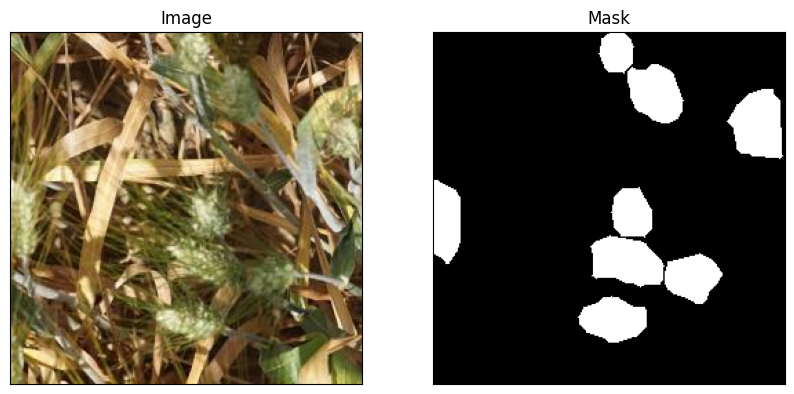

In [15]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [16]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


In [17]:

from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs


In [29]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


In [30]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)



In [31]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [32]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)


In [33]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)


pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [34]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


In [35]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [42]:
def calculate_ap(ground_truth, predicted_probabilities, threshold=0.5):
    # Binarize predictions based on the threshold
    predicted_bin = (predicted_probabilities > threshold).astype(int)
    
    # Flatten arrays to treat each pixel as an individual label for AP calculation
    ground_truth_flat = ground_truth.flatten()
    predicted_flat = predicted_bin.flatten()
    
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(ground_truth_flat, predicted_flat)
    
    # Calculate AP
    ap = auc(recall, precision)
    return ap

In [43]:
epoch_ap_scores = []


In [41]:
"""
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 25

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
    

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     
"""

'\nfrom tqdm import tqdm\nfrom statistics import mean\nimport torch\nfrom torch.nn.functional import threshold, normalize\n\n#Training loop\nnum_epochs = 25\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nmodel.to(device)\n\nmodel.train()\nfor epoch in range(num_epochs):\n    epoch_losses = []\n    for batch in tqdm(train_dataloader):\n      # forward pass\n      outputs = model(pixel_values=batch["pixel_values"].to(device),\n                      input_boxes=batch["input_boxes"].to(device),\n                      multimask_output=False)\n\n      # compute loss\n      predicted_masks = outputs.pred_masks.squeeze(1)\n      ground_truth_masks = batch["ground_truth_mask"].float().to(device)\n      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))\n\n      # backward pass (compute gradients of parameters w.r.t. loss)\n      optimizer.zero_grad()\n      loss.backward()\n\n      # optimize\n      optimizer.step()\n      epoch_losses.append(loss.item())\n    \n\n  

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/wheat_model_checkpoint.pth")


In [39]:
import numpy as np

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc

# Assuming 'seg_loss', 'train_dataloader', 'model', and 'optimizer' are defined

def calculate_ap(ground_truth, predicted_probabilities):
    # Flatten the arrays to treat each pixel as a label
    ground_truth_flat = ground_truth.flatten()
    predicted_flat = predicted_probabilities.flatten()
    
    # Calculate precision and recall at different thresholds
    precision, recall, _ = precision_recall_curve(ground_truth_flat, predicted_flat)
    
    # Calculate AP as the area under the precision-recall curve
    ap = auc(recall, precision)
    return ap

num_epochs = 25
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

epoch_losses = []  # Track loss for each epoch
epoch_ap_scores = []  # Track mean AP for each epoch

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    ap_scores = []  # Track AP for each batch

    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        batch_losses.append(loss.item())

        # Calculate and track AP
        with torch.no_grad():
            predicted_probabilities = torch.sigmoid(predicted_masks).cpu().numpy()
            ground_truth = ground_truth_masks.cpu().numpy()
            ap = calculate_ap(ground_truth, predicted_probabilities)
            ap_scores.append(ap)
    torch.save(model.state_dict(), "/kaggle/working/wheat_model_{epoch}_checkpoint.pth")
    # Calculate mean metrics for the epoch
    mean_loss = np.mean(batch_losses)
    mean_ap = np.mean(ap_scores)
    epoch_losses.append(mean_loss)
    epoch_ap_scores.append(mean_ap)

    # Print epoch summary
    print(f'EPOCH: {epoch} - Mean Loss: {mean_loss} - Mean AP: {mean_ap}')
    torch.save(model.state_dict(), "/kaggle/working/wheat_model_{epoch}_checkpoint.pth")
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_ap_scores, label='Mean AP', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Average Precision')
plt.title('Mean Average Precision')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), "/kaggle/working/wheat_model20_checkpoint.pth")


100%|██████████| 4535/4535 [47:47<00:00,  1.58it/s]


EPOCH: 0 - Mean Loss: 0.27237618933447205 - Mean AP: 0.9038791976167021


100%|██████████| 4535/4535 [47:46<00:00,  1.58it/s]


EPOCH: 1 - Mean Loss: 0.25745116667996565 - Mean AP: 0.9116865293676087


 77%|███████▋  | 3512/4535 [37:01<10:45,  1.58it/s]

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
     

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/kaggle/working/wheat_model_checkpoint.pth"))


In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)


In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [ ]:
from patchify import patchify
import tifffile

# Correctly loading the single RGB image
large_test_image = tifffile.imread("/kaggle/working/tiff_images/7e6a307fd_jpg.rf.5087bd2bfd9b4ae5ead115ecec174763.tif")

# Since the shape is (640, 640, 3), you don't need to select [1]
print(large_test_image.shape)  # This should print (640, 640, 3)

# Directly apply patchify with the window_shape including the channel dimension
patches = patchify(large_test_image, (256, 256, 3), step=256)

# Process patches...


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)
     

print(np.array(input_points).shape)


In [ ]:
print(patches.shape)


In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 1

# Selectelected patch for segmentation
random_array = patches[i, j, 0, :, :, :]


single_patch = Image.fromarray(random_array.astype('uint8'))
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [ ]:
import numpy as np

# Assuming single_patch_prediction is your binary mask with shape (256, 256)
# And random_array is your original RGB image patch with shape (256, 256, 3)

# Convert the binary mask to an RGB mask with a specific color (e.g., red)
rgb_mask = np.zeros_like(random_array)  # Create an empty mask with the same shape as the RGB image
rgb_mask[single_patch_prediction == 1] = [255, 0, 0]  # Highlight segmented areas in red


In [ ]:
# Define the opacity for the overlay
opacity = 0.5

# Blend the original image with the segmentation mask
segmented_image = (opacity * rgb_mask + (1 - opacity) * random_array).astype(np.uint8)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(segmented_image)
plt.axis('off')  # Hide axis ticks and labels
plt.show()
